In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from toolz import curry

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

In [4]:
url='https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/refs/heads/master/causal-inference-for-the-brave-and-true/data/ice_cream_sales_rnd.csv'
prices_rnd = pd.read_csv(url) # loads random data
url='https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/refs/heads/master/causal-inference-for-the-brave-and-true/data/ice_cream_sales.csv'
prices = pd.read_csv(url)

In [6]:
m1 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit()
m1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,200.1113,3.188,62.769,0.000,193.862,206.361
C(weekday)[T.2],-118.5501,1.824,-64.992,0.000,-122.126,-114.975
C(weekday)[T.3],-120.3301,1.873,-64.237,0.000,-124.002,-116.658
C(weekday)[T.4],-118.2078,1.855,-63.713,0.000,-121.845,-114.571
C(weekday)[T.5],-119.6481,1.870,-63.984,0.000,-123.314,-115.983
C(weekday)[T.6],-119.5366,1.855,-64.428,0.000,-123.174,-115.900
C(weekday)[T.7],0.5810,1.959,0.297,0.767,-3.259,4.421
price,-2.6762,0.505,-5.297,0.000,-3.667,-1.686
price:C(weekday)[T.2],12.9438,0.283,45.767,0.000,12.389,13.498
price:C(weekday)[T.3],13.2905,0.292,45.583,0.000,12.719,13.862


In [7]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"

np.random.seed(1)
m2 = GradientBoostingRegressor()
m2.fit(prices[X], prices[y]);

In [8]:
print("Train Score:", m2.score(prices[X], prices[y]))
print("Test Score:", m2.score(prices_rnd[X], prices_rnd[y]))

Train Score: 0.9251704824568053
Test Score: 0.7711074163447711


In [9]:
def predict_sensitivity(model, price_df, h=0.01):
    return (model.predict(price_df.assign(price=price_df["price"]+h))
            - model.predict(price_df)) / h

np.random.seed(123)
prices_rnd_pred = prices_rnd.assign(**{
    "sensitivity_m_pred": predict_sensitivity(m1, prices_rnd), ## sensitivity model
    "pred_m_pred": m2.predict(prices_rnd[X]), ## predictive model
    "rand_m_pred": np.random.uniform(size=prices_rnd.shape[0]), ## random model
})

prices_rnd_pred.head()

,temp,weekday,cost,price,sales,sensitivity_m_pred,pred_m_pred,rand_m_pred
0,25.8,1,0.3,7,230,-13.096964,224.067406,0.696469
1,22.7,3,0.5,4,190,1.054695,189.889147,0.286139
2,33.7,7,1.0,5,237,-17.362642,237.255157,0.226851
3,23.0,4,0.5,5,193,0.564985,186.688619,0.551315
4,24.4,1,1.0,3,252,-13.717946,250.342203,0.719469


In [10]:
@curry
def sensitivity(data, y, t):
        # line coeficient for the one variable linear regression 
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

In [11]:
def sensitivity_by_band(df, pred, y, t, bands=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=bands)}) # makes quantile partitions
            .groupby(f"{pred}_band")
            .apply(sensitivity(y=y, t=t))) # estimate the sensitivity on each partition

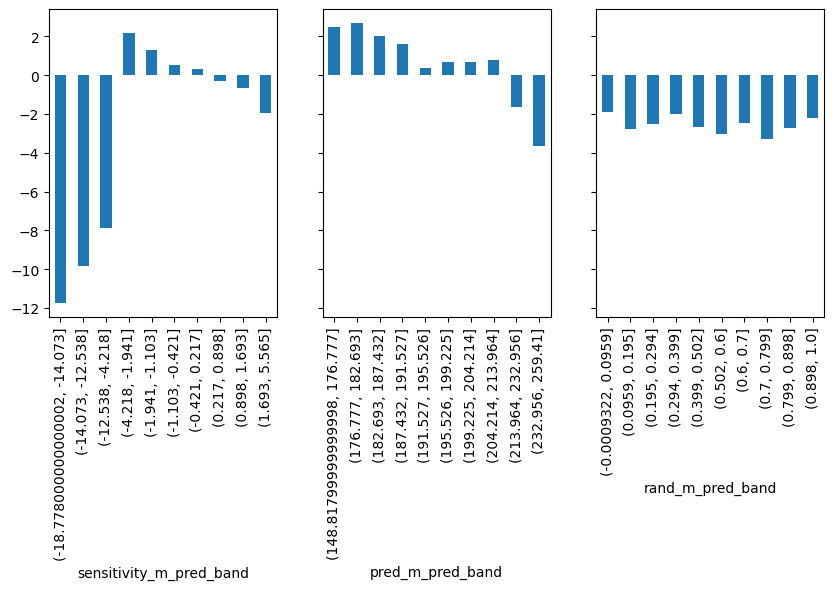

In [12]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))
for m, ax in zip(["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"], axs):
    sensitivity_by_band(prices_rnd_pred, m, "sales", "price").plot.bar(ax=ax)

In [13]:
def cumulative_sensitivity_curve(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    
    # orders the dataset by the `prediction` column
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    # create a sequence of row numbers that will define our Ks
    # The last item is the sequence is all the rows (the size of the dataset)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # cumulative computes the sensitivity. First for the top min_periods units.
    # then for the top (min_periods + step*1), then (min_periods + step*2) and so on
    return np.array([sensitivity(ordered_df.head(rows), y, t) for rows in n_rows])

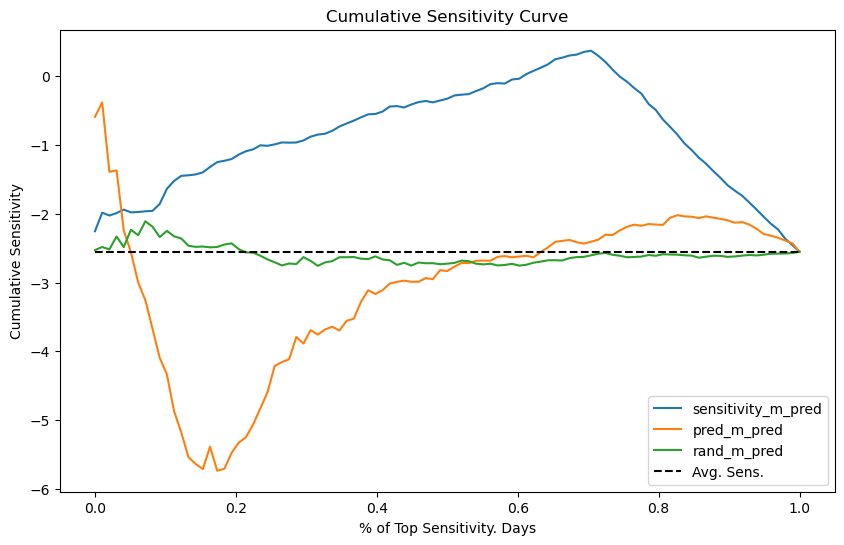

In [14]:
plt.figure(figsize=(10,6))

for m in ["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_sens = cumulative_sensitivity_curve(prices_rnd_pred, m, "sales", "price", min_periods=100, steps=100)
    x = np.array(range(len(cumu_sens)))
    plt.plot(x/x.max(), cumu_sens, label=m)

plt.hlines(sensitivity(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Sens.")
plt.xlabel("% of Top Sensitivity. Days")
plt.ylabel("Cumulative Sensitivity")
plt.title("Cumulative Sensitivity Curve")
plt.legend();

In [15]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    ## add (rows/size) as a normalizer. 
    return np.array([sensitivity(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

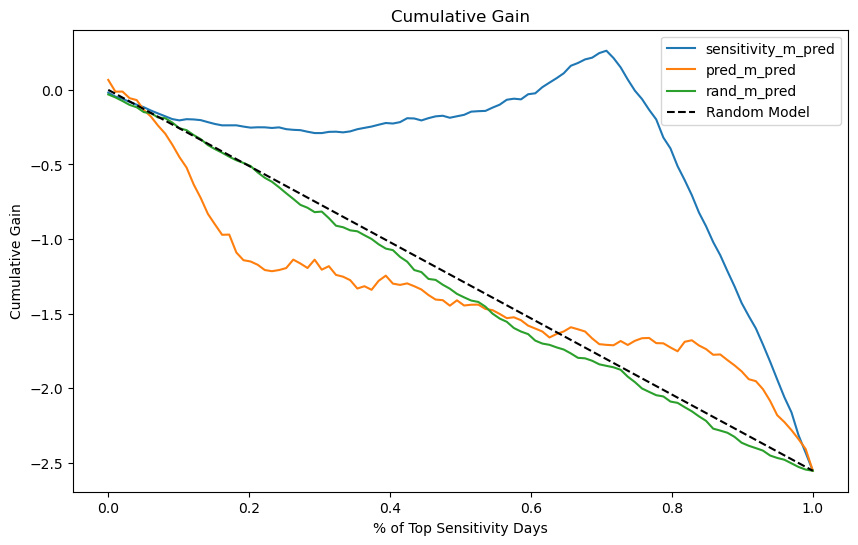

In [16]:
plt.figure(figsize=(10,6))

for m in ["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_gain = cumulative_gain(prices_rnd_pred, m, "sales", "price", min_periods=50, steps=100)
    x = np.array(range(len(cumu_gain)))
    plt.plot(x/x.max(), cumu_gain, label=m)
    
plt.plot([0, 1], [0, sensitivity(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Sensitivity Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain")
plt.legend();

In [17]:
def sensitivity_ci(df, y, t, z=1.96):
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = sensitivity(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    e = df[y] - (beta0 + beta1*df[t])
    se = np.sqrt(((1/(n-2))*np.sum(e**2))/np.sum((df[t]-t_bar)**2))
    return np.array([beta1 - z*se, beta1 + z*se])

In [18]:
def cumulative_sensitivity_curve_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # just replacing a call to `sensitivity` by a call to `sensitivity_ci`
    return np.array([sensitivity_ci(ordered_df.head(rows), y, t)  for rows in n_rows])

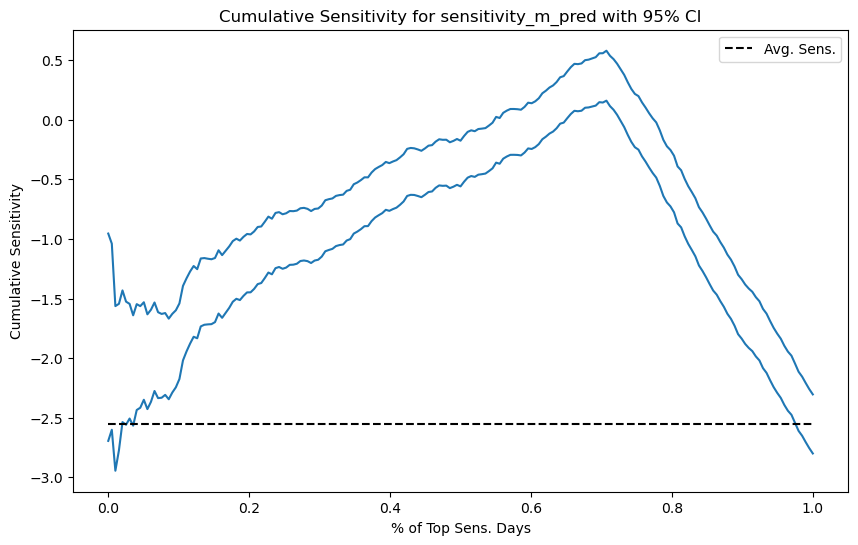

In [19]:
plt.figure(figsize=(10,6))

cumu_gain_ci = cumulative_sensitivity_curve_ci(prices_rnd_pred, "sensitivity_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain_ci)))
plt.plot(x/x.max(), cumu_gain_ci, color="C0")

plt.hlines(sensitivity(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Sens.")

plt.xlabel("% of Top Sens. Days")
plt.ylabel("Cumulative Sensitivity")
plt.title("Cumulative Sensitivity for sensitivity_m_pred with 95% CI")
plt.legend();

In [20]:
def cumulative_gain_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([sensitivity_ci(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

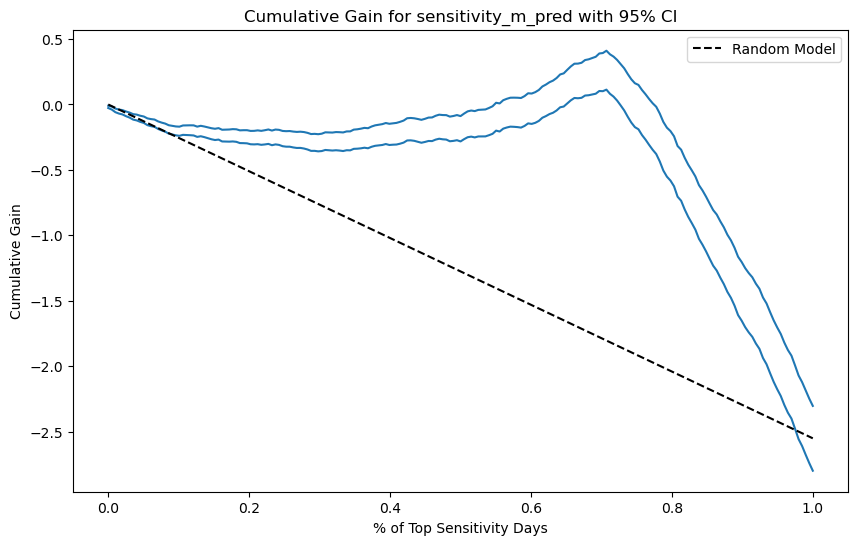

In [21]:
plt.figure(figsize=(10,6))

cumu_gain = cumulative_gain_ci(prices_rnd_pred, "sensitivity_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain)))
plt.plot(x/x.max(), cumu_gain, color="C0")

plt.plot([0, 1], [0, sensitivity(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Sensitivity Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain for sensitivity_m_pred with 95% CI")
plt.legend();